In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-11-27-22-46-55-562017


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories

env_id = "BreakoutNoFrameskip-v4"
env_type = "atari"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, 'atari', 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecFrameStack(env, 4)
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

/home/dsbrown/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    #print(obs_highs)
    #print(obs_lows)
    #return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0
    return obs / 255.0


In [4]:
checkpoint_min = 100
checkpoint_max = 1500
checkpoint_step = 100
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 1000:
        checkpoints.append('00' + str(i))
    elif i < 10000:
        checkpoints.append('0' + str(i))
print(checkpoints)

['00100', '00200', '00300', '00400', '00500', '00600', '00700', '00800', '00900', '01000', '01100', '01200', '01300', '01400', '01500']


In [5]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/breakout/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 1
    for i in range(episode_count):
        done = False
        traj = []
        r = 0
        
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(normalize_state(ob))
            steps += 1
            acc_reward += r[0]
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
        print("traj length", len(traj))
        print("demo length", len(demonstrations))
        demonstrations.append(traj)
        learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00100, steps: 389, return: 6.0
traj length 389
demo length 0
checkpoint: 00200, steps: 421, return: 7.0
traj length 421
demo length 1
checkpoint: 00300, steps: 755, return: 23.0
traj length 755
demo length 2
checkpoint: 00400, steps: 961, return: 30.0
traj length 961
demo length 3
checkpoint: 00500, steps: 905, return: 35.0
traj length 905
demo length 4
checkpoint: 00600, steps: 1158, return: 36.0
traj length 1158
demo length 5
checkpoint: 00700, steps: 1619, return: 91.0
traj length 1619
demo length 6
checkpoint: 00800, steps: 1264, return: 62.0
traj length 1264
demo length 7
checkpoint: 00900, steps: 850, return: 41.0
traj length 850
demo length 8
checkpoint: 01000, steps: 1130, return: 54.0
traj length 1130
demo length 9
checkpoint: 01100, steps: 1388, return: 67.0
traj length 1388
demo length 10
checkpoint: 01200, steps: 1841, return: 160.0
traj length 1841
demo length 11
checkpoint: 01300, steps: 1218, return: 63.0
traj length 1218
demo length 12
checkpoint: 01400, ste

Let's plot the returns to see if they are roughly monotonically increasing.

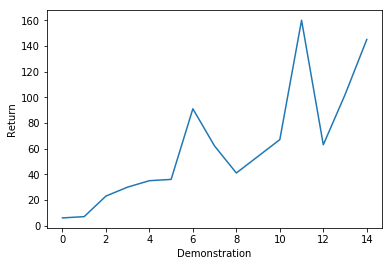

In [6]:
plt.plot(learning_returns)
plt.xlabel("Demonstration")
plt.ylabel("Return")
plt.savefig("breakoutLearningPPO.png")
plt.show()

15
15
[6.0, 7.0, 23.0, 30.0, 35.0, 36.0, 91.0, 62.0, 41.0, 54.0, 67.0, 160.0, 63.0, 102.0, 145.0]
[6.0, 7.0, 23.0, 30.0, 35.0, 36.0, 91.0, 62.0, 41.0, 54.0, 67.0, 160.0, 63.0, 102.0, 145.0]


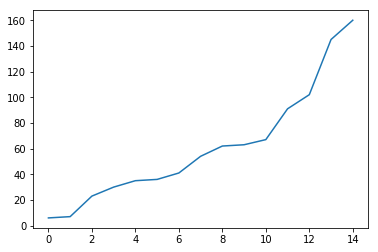

In [7]:
print(len(learning_returns))
print(len(demonstrations))
print([a[0] for a in zip(learning_returns, demonstrations)])
#cheat and sort them to see if it helps learning
sorted_demos = [x for _, x in sorted(zip(learning_returns,demonstrations), key=lambda pair: pair[0])]

sorted_returns = sorted(learning_returns)
print(learning_returns)
plt.plot(sorted_returns)

Split the data into train and validation sets

In [9]:
train_demos = []
train_returns = []
valid_demos = []
valid_returns = []

for i,d in enumerate(sorted_demos):
    print(i)
    if i % 5 is not 0:
        train_demos.append(d)
        train_returns.append(sorted_returns[i])
    else:
        valid_demos.append(d)
        valid_returns.append(sorted_returns[i])

print(train_returns)
print(valid_returns)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[7.0, 23.0, 30.0, 35.0, 41.0, 54.0, 62.0, 63.0, 91.0, 102.0, 145.0, 160.0]
[6.0, 36.0, 67.0]


Now I want to build a neural network to predict the reward the learner is trying to optimize. The inputs are 84x84x4 grayscale images. I'm going to try and use the NIPS architecture from DeepMind.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 16, 7, stride=3)
        self.conv2 = nn.Conv2d(16, 16, 5, stride=2)
        self.conv3 = nn.Conv2d(16, 16, 3, stride=1)
        self.conv4 = nn.Conv2d(16, 16, 3, stride=1)
        self.fc1 = nn.Linear(1936, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2) #get into NCHW format
            #compute forward pass of reward network
            x = F.leaky_relu(self.conv1(x))
            x = F.leaky_relu(self.conv2(x))
            x = x.view(-1, 1936)
            x = F.leaky_relu(self.fc1(x))
            r = torch.sigmoid(self.fc2(x)) #clip reward?
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 8, 8, stride=4)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2)
        self.fc1 = nn.Linear(9*9*16, 1)
        #self.fc2 = nn.Linear(256, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(-1, 9*9*16)
            r = torch.tanh(self.fc1(x))
            
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [16]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j and give classification label to later one
        j = np.random.randint(len(trajectories)) 
        i = np.random.randint(len(trajectories))
        while(i == j):
            i = np.random.randint(len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        if i > j:
            labels = np.array([[0]])
        else:
            labels = np.array([[1]])
            
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 50 == 49:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 50)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

In [12]:
#doesn't work on my laptop, CUDA out of memory!!!
reward = Net()
reward.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward.parameters(), lr = 0.00001, weight_decay=0.001)
learn_reward(reward, optimizer, train_demos, 200)

49 85.81643188476562
99 75.64207397460937
149 6.40574951171875
199 109.47626831054687
finished training


Print out learned return for all demos. should be roughly increasing

In [13]:
with torch.no_grad():
    print(torch.cat([reward.cum_return(torch.from_numpy(np.array(traj)).float().to(device)) for traj in demonstrations]))

tensor([[ 156.5352],
        [ 169.0120],
        [ 302.2957],
        [ 385.0208],
        [ 361.6495],
        [ 464.3006],
        [ 645.1809],
        [ 503.8420],
        [ 340.0422],
        [ 451.7923],
        [ 552.8664],
        [ 730.7595],
        [ 485.9951],
        [ 546.8789],
        [ 594.9554],
        [ 610.5115],
        [ 867.9128],
        [ 751.1854],
        [ 562.1641],
        [ 853.5453],
        [ 699.6649],
        [ 873.6005],
        [ 743.1573],
        [ 537.1192],
        [ 748.8412],
        [ 812.3763],
        [ 969.8518],
        [ 943.1548],
        [ 854.4624],
        [ 546.6717],
        [1943.7161],
        [ 684.9302],
        [3776.6694],
        [ 745.4275],
        [ 498.9506],
        [ 996.7360]], device='cuda:0')


Look at predicted reward over last demo. It's all +1 since demos are monotonically increasing. Maybe need to truncate demos to fixed length?

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/dsbrown/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


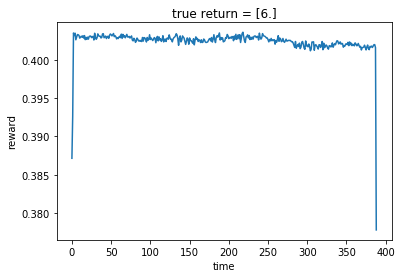

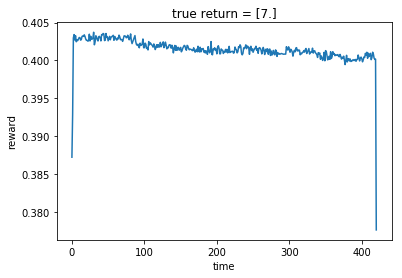

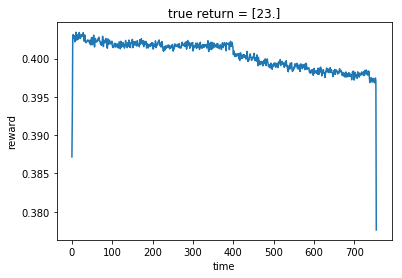

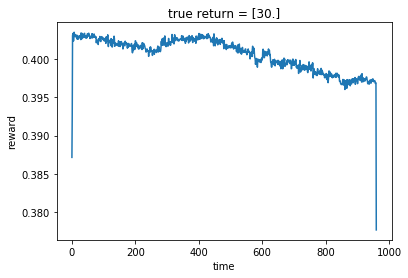

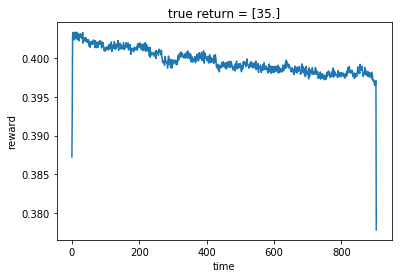

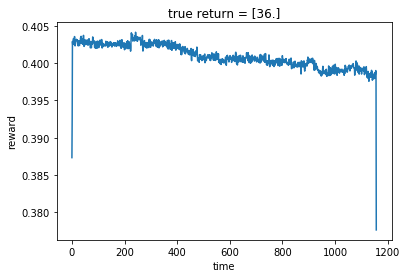

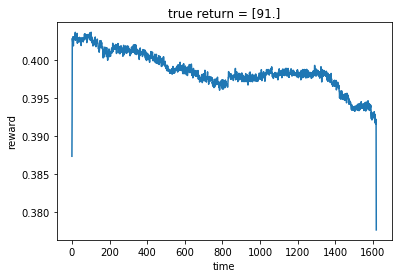

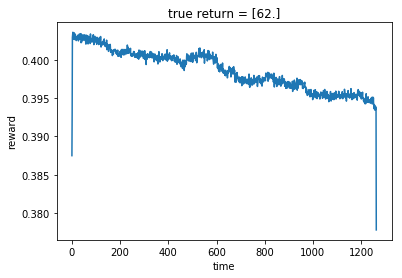

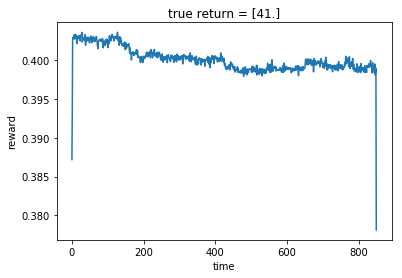

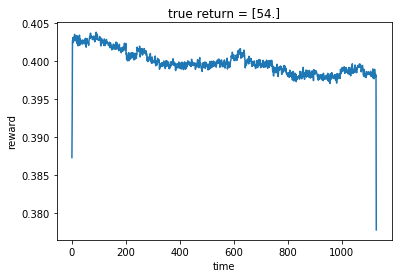

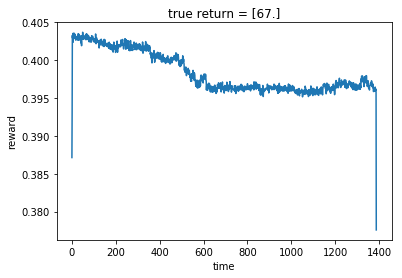

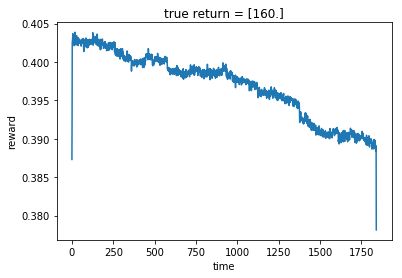

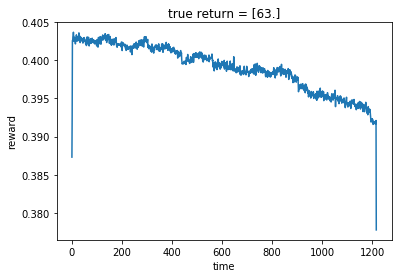

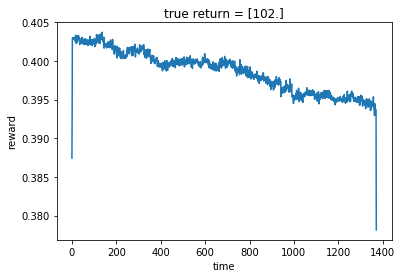

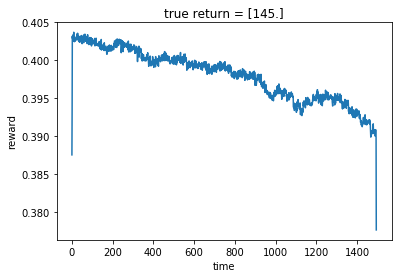

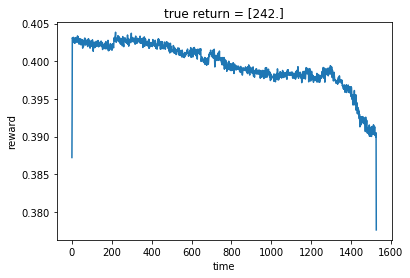

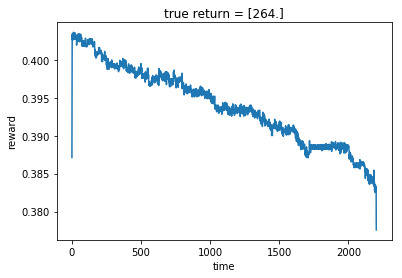

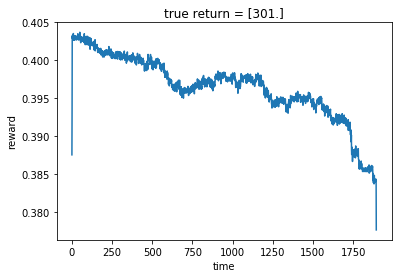

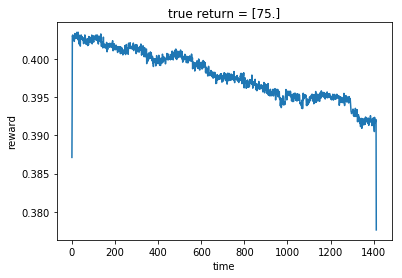

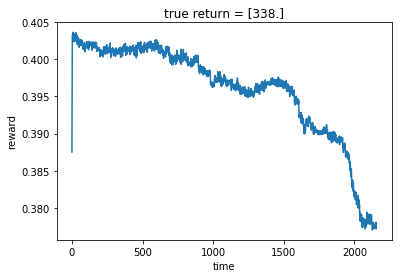

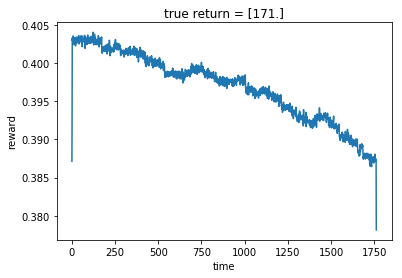

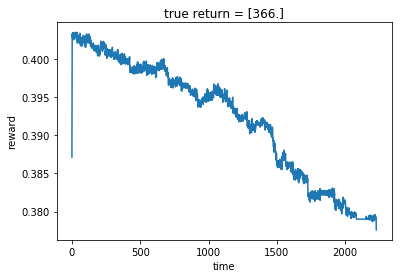

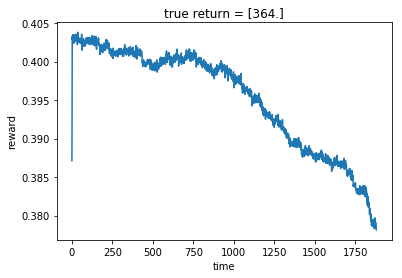

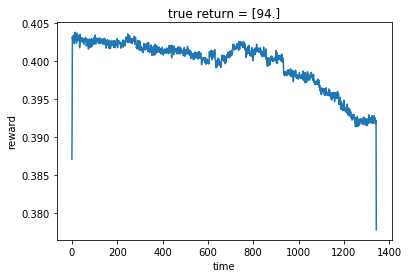

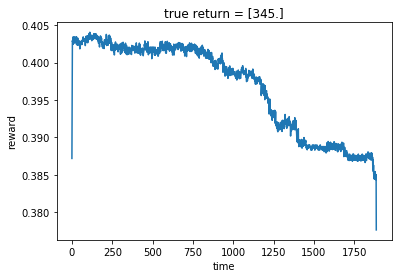

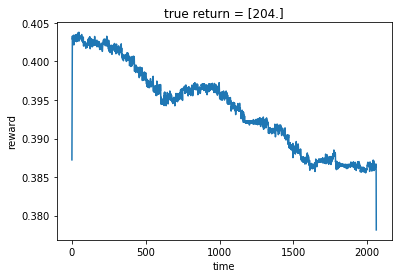

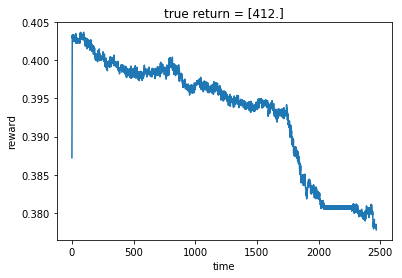

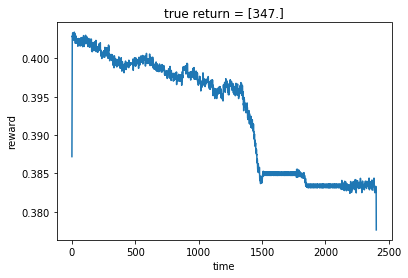

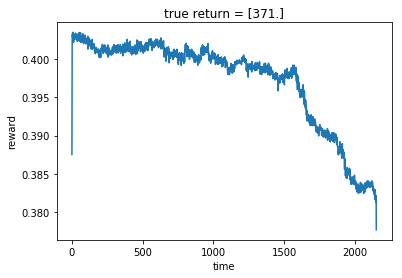

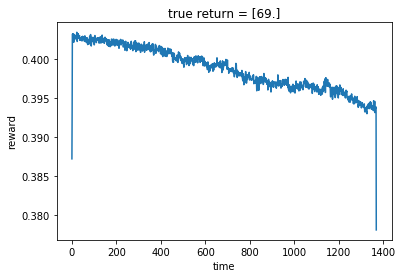

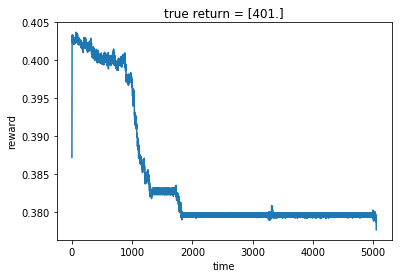

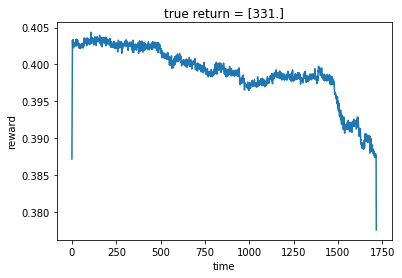

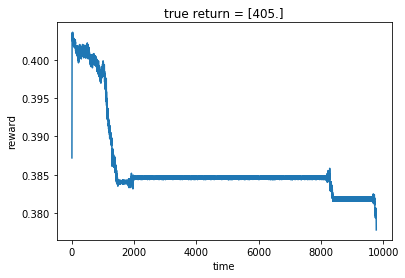

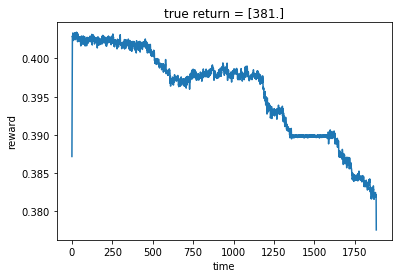

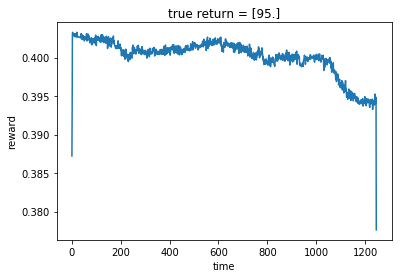

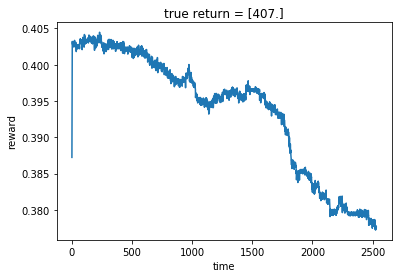

In [14]:

#for last demo

cnt = 0
with torch.no_grad():
    for d in demonstrations:
        rewards = []
        print(cnt)
        for s in d:
            r = reward.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(learning_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()


Trying shorter snippets of the demos, should use a sliding window over all demos to get lots of training data, but just  trying the last H frames for now, where H is length of first (the shortest) demo 

In [17]:
H = len(train_demos[0])
print(H)
demos_fh = [d[len(d)-H:-1] for d in train_demos]
print(len(demos_fh))
reward_fh = Net()
reward_fh.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward_fh.parameters(),  lr = 0.0001)
learn_reward(reward_fh, optimizer, demos_fh, 2000)

421
12
49 0.163712158203125
99 0.1105792236328125
149 0.09524383544921874
199 0.0227716064453125
249 0.01506103515625
299 0.0213336181640625
349 0.0128973388671875
399 0.00499237060546875
449 0.00467132568359375
499 0.0029583740234375
549 0.00198944091796875
599 0.00640106201171875
649 0.00053192138671875


KeyboardInterrupt: 

See what predicted returns look like compared to actual

In [19]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in train_demos]
for i, p in enumerate(pred_returns):
    print(i,p,train_returns[i])

0 172.36871337890625 7.0
1 312.87469482421875 23.0
2 403.372314453125 30.0
3 384.50030517578125 35.0
4 368.3806457519531 41.0
5 497.38720703125 54.0
6 565.0969848632812 62.0
7 547.3466186523438 63.0
8 742.9056396484375 91.0
9 635.5021362304688 102.0
10 694.6373291015625 145.0
11 864.6025390625 160.0


420
420
420
420
420
420
420
420
420
420
420
420
0
1
2
3
4
5
6
7
8
9
10
11


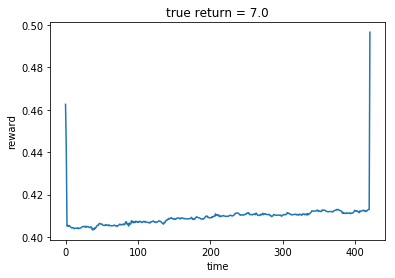

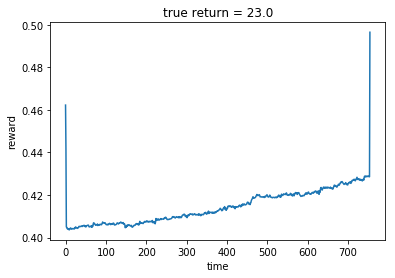

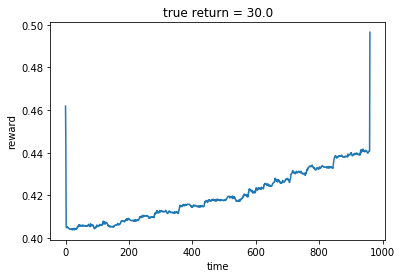

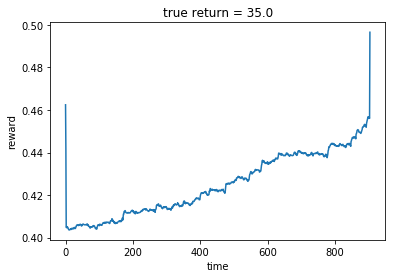

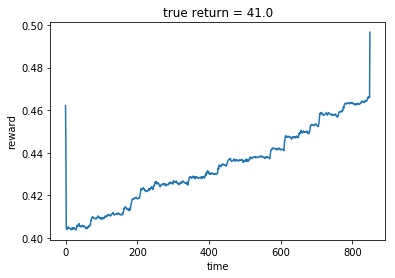

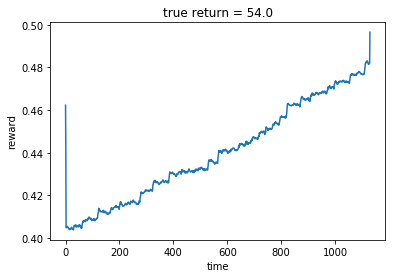

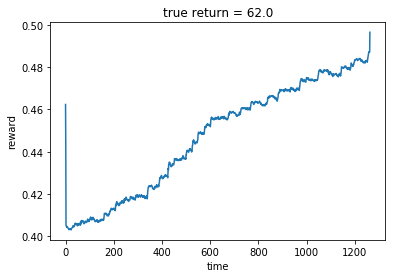

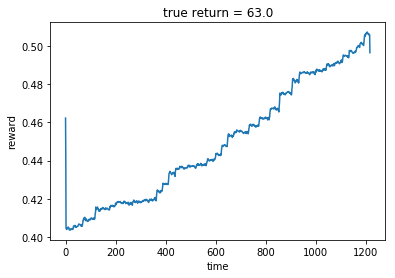

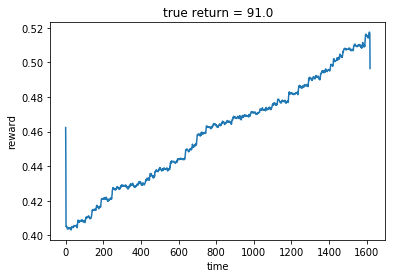

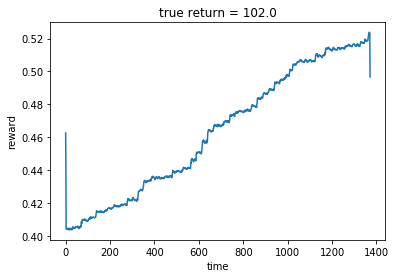

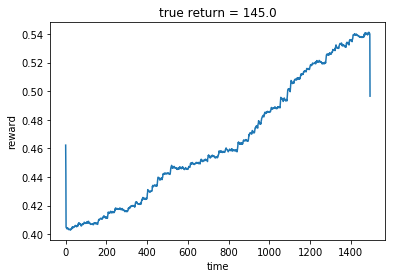

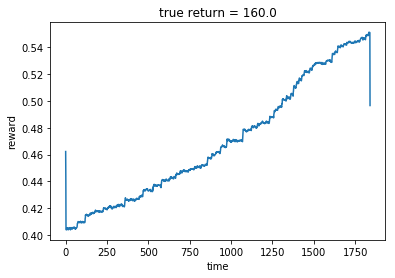

In [20]:
#print out the actual time series of rewards predicted by nnet for each trajectory.
#They are monotonically increasing, so that's good!
for d in demos_fh:
    print(len(d))

cnt = 0
with torch.no_grad():
    for d in train_demos:
        rewards = []
        print(cnt)
        for s in d:
            r = reward_fh.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(train_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()

Check validation accuracy

In [21]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

0 158.86569213867188 6.0
1 508.79510498046875 36.0
2 627.7069702148438 67.0


In [22]:
torch.save(reward_fh.state_dict(), "./breakout_1_15_lastXreward_sorted.params")

Okay. So now we want to optimize a policy using the learned reward to see how well it can perform if we run RL to convergence on it...